In [770]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle as pk,numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec as gs
import seaborn as sns
from scipy import stats
import pandas as pd

### Load reporter strain data along with their protein features

In [771]:
pooled_stats = pd.read_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/reporter_assay_features.csv')
train_df = pooled_stats[pooled_stats['as_validation']==0] #data generated before August
validation_df = pooled_stats[pooled_stats['as_validation']==1] #data generated after August

total_feature_cols = pooled_stats.columns[15:]
#
print("{} entries found in training set and {} entries found in a independently generated validation dataset.".format(len(train_df),len(validation_df)))
print("A total number of {} features extracted.".format(len(total_feature_cols)))

54 entries found in training set and 18 entries found in a independently generated validation dataset.
A total number of 485 features extracted.


### Examine training set

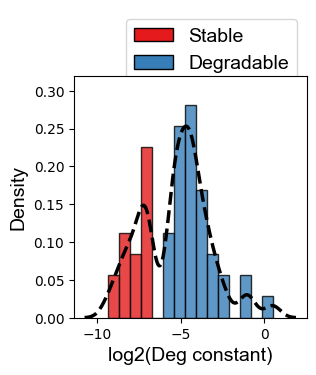

In [622]:
# The log2 transformed degradation constant values seemingly fall into two main categories:
from matplotlib.patches import Rectangle,Circle,Ellipse
fig=plt.figure(figsize=(3,4))
grids= gs(5,1,hspace=0.5,wspace=0.5)
ax0 = fig.add_subplot(grids[0,0])
ax1 = fig.add_subplot(grids[1:,0])
N, bins, patches=ax1.hist(train_df['log2(Deg constant)'],bins=15,
                          density=True,ec='black',fc='lightgrey',alpha=0.8)
ax1.set_xlabel('log2(Deg constant)',fontsize=14,fontname='Arial')
ax1.set_ylabel('Density',fontsize=14,fontname='Arial')
for i in range(0,4):
    patches[i].set_facecolor(colormaps.get_cmap('Set1')(0))
for i in range(4,15):
    patches[i].set_facecolor(colormaps.get_cmap('Set1')(1))
    
sns.kdeplot(train_df['log2(Deg constant)'].values,
            bw_adjust=0.5,
            color='black',lw=2.5,fill=False,ls='--',ax=ax1,);
ax1.set_ylim(0,0.32)
handles = [Ellipse((0,0),0.1,0.1,color=colormaps.get_cmap('Set1')(i),ec="k") for i in range(2)]
labels= ["Stable","Degradable"]
ax0.legend(handles, labels,loc=1,prop={'family':'Arial','size':14})
ax0.axis('off')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231206_trainingset_group.svg',
            bbox_inches='tight')

### Coarse hyperparameter tuning

In [623]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

X_train = train_df[total_feature_cols].values
y_train = train_df['log2(Deg constant)'].values

param_grid = {'n_estimators':[100,150,200],
              'max_depth':[None,2,5],
              'min_samples_split':[2,3,6,8],
              'min_samples_leaf':[5,8,12],
              'max_features':[50,100,200]}

model = RandomForestRegressor(random_state=39)
nested_scores=[]

clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,n_jobs=24)
clf.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=39), n_jobs=24,
             param_grid={'max_depth': [None, 2, 5],
                         'max_features': [50, 100, 200],
                         'min_samples_leaf': [5, 8, 12],
                         'min_samples_split': [2, 3, 6, 8],
                         'n_estimators': [100, 150, 200]})

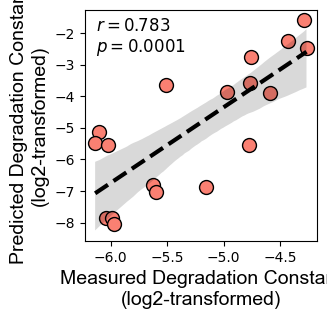

In [624]:
from scipy.stats import pearsonr
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot()
pred = clf.best_estimator_.predict(validation_df[total_feature_cols].values)
val = validation_df['log2(Deg constant)']

ax.scatter(pred,val,color='salmon',ec='black',s=100)
sns.regplot(x=pred,y=val,scatter=False,color='black',line_kws={'lw':3,'ls':'--'})


r,p = pearsonr(val,pred)
ax.text(0.05,0.82,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax.transAxes,fontsize=12,fontname='Arial',ha='left')
#ax.set_xlim(-6,-4.4)
ax.set_xlabel('Measured Degradation Constant\n(log2-transformed)',fontsize=14,fontname='Arial')
ax.set_ylabel('Predicted Degradation Constant\n(log2-transformed)',fontsize=14,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_coarse_parameter_tuning.svg',
            bbox_inches='tight')

### Feature selection

In [625]:
from sklearn.feature_selection import SelectFromModel

sel_ = SelectFromModel(RandomForestRegressor(random_state=31,**clf.best_params_))
sel_.fit(X_train,y_train)
fval = np.array(total_feature_cols)[sel_.get_support()]
print(fval)
print('After feature selection, {} out of {} features will be used for downstream analysis.'.format(len(fval),len(total_feature_cols)))

pd.DataFrame(fval,columns=['Selected_features']).to_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/202311_pred_selected_features.csv')

['max_plddt' 'total_residues' 'Full_BLOSUM7' 'Full_VHSE3' 'flDPnn_STD'
 'flDPnn>0.2_count' 'pLDDT_max' 'pLDDT_STD' 'Nterm15_BLOSUM1'
 'Nterm15_BLOSUM2' 'Nterm15_BLOSUM9' 'Nterm15_F4' 'Nterm15_KF5'
 'Nterm15_E3' 'Nterm15_E5' 'Nterm15_ST4' 'Nterm15_T1' 'Nterm15_T3'
 'Cterm15_BLOSUM3' 'Cterm15_KF6' 'Cterm15_MSWHIM1' 'Cterm15_ProtFP8'
 'Cterm15_SV1' 'Cterm15_SVGER4' 'Nterm15_flDPnn_Q1' 'Nterm15_flDPnn_Q3'
 'Nterm15_pLDDT_mean' 'Nterm15_pLDDT_median' 'Nterm15_pLDDT_Q3'
 'Nterm30_BLOSUM1' 'Nterm30_BLOSUM3' 'Nterm30_BLOSUM4' 'Nterm30_KF5'
 'Nterm30_KF9' 'Nterm30_E1' 'Nterm30_ProtFP1' 'Nterm30_ProtFP7'
 'Nterm30_ProtFP8' 'Nterm30_SV4' 'Nterm30_SVGER3' 'Nterm30_SVGER8'
 'Nterm30_SVGER11' 'Nterm30_VHSE1' 'Nterm30_VHSE7' 'Nterm30_Z1'
 'Cterm30_BLOSUM2' 'Cterm30_PP3' 'Cterm30_F1' 'Cterm30_F4' 'Cterm30_KF6'
 'Cterm30_MSWHIM1' 'Cterm30_ST6' 'Nterm30_flDPnn_mean'
 'Nterm30_flDPnn_median' 'Nterm30_flDPnn_Q3' 'Cterm30_flDPnn_IQR'
 'Nterm30_pLDDT_IQR' 'Msm_PI']
After feature selection, 58 out of 527 fea

### Hyperparameter fine-tuning

In [626]:
X_train_selected = train_df[fval].values #use the top 10% features
y_train_selected = train_df['log2(Deg constant)'].values

param_grid = {'n_estimators':[75,100],
              'max_depth':[5], #fix to 4 to suppress over-fitting
              'min_samples_split':[2,3,5],
              'min_samples_leaf':[6,8,10],
              'max_features':[50,60,80]}


best_models=[]
for i in range(36,55):
    model = RandomForestRegressor(random_state=i)
    clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,n_jobs=24)
    clf.fit(X_train_selected,y_train_selected)
    best_models.append(clf)

pvals = []
for m in best_models:
    pred = m.best_estimator_.predict(validation_df[fval].values)
    val = validation_df['log2(Deg constant)']
    pvals.append(pearsonr(val,pred)[1])

best_models[np.argmin(pvals)].best_estimator_

RandomForestRegressor(max_depth=5, max_features=50, min_samples_leaf=8,
                      random_state=45)

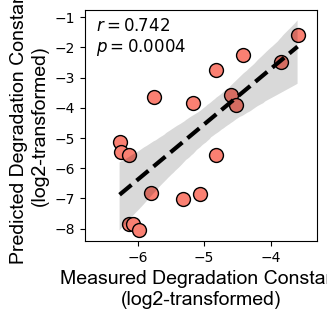

In [627]:
from scipy.stats import pearsonr
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot()
pred = best_models[np.argmin(pvals)].best_estimator_.predict(validation_df[fval].values)
val = validation_df['log2(Deg constant)']
ax.scatter(pred,val,color='salmon',ec='black',s=100)
sns.regplot(x=pred,y=val,scatter=False,color='black',line_kws={'lw':3,'ls':'--'})


r,p = pearsonr(val,pred)
ax.text(0.05,0.82,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax.transAxes,fontsize=12,fontname='Arial',ha='left')
ax.set_xlim(-6.8,-3.3)
ax.set_xlabel('Measured Degradation Constant\n(log2-transformed)',fontsize=14,fontname='Arial')
ax.set_ylabel('Predicted Degradation Constant\n(log2-transformed)',fontsize=14,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_hyperparameter_finetuning.svg',
            bbox_inches='tight')

### Show best model parameters

In [628]:
best_models[np.argmin(pvals)].best_estimator_

RandomForestRegressor(max_depth=5, max_features=50, min_samples_leaf=8,
                      random_state=45)

### Save best model

In [629]:
import pickle as pk
pk.dump(best_models[np.argmin(pvals)].best_estimator_,
        open('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/202311_best_pred_model.pk','wb'))

### Explore feature importance

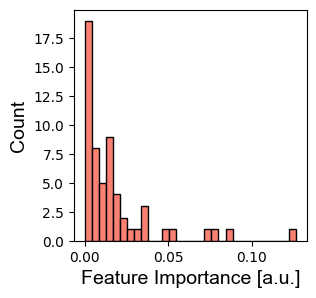

In [630]:
fig=plt.figure(figsize=(3,3))
plt.hist(best_models[np.argmin(pvals)].best_estimator_.feature_importances_,
         bins=30,fc='salmon',ec='black');
plt.ylabel('Count',fontname='Arial',fontsize=14)
plt.xlabel('Feature Importance [a.u.]',fontname='Arial',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_hyperparameter_finetuning_FImportance.svg',
            bbox_inches='tight')

### Not all features matter

In [631]:
non_zero_features = fval[best_models[np.argmin(pvals)].best_estimator_.feature_importances_>0]
print(non_zero_features)
print('{} out of {} selected features had an importance score over 0.'.format(len(non_zero_features),len(fval)))
pd.DataFrame(non_zero_features,columns=['Selected_features']).to_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/202311_pred_selected_features_mini.csv')

['max_plddt' 'total_residues' 'flDPnn_STD' 'flDPnn>0.2_count' 'pLDDT_max'
 'pLDDT_STD' 'Nterm15_BLOSUM2' 'Nterm15_BLOSUM9' 'Nterm15_F4'
 'Nterm15_KF5' 'Nterm15_E3' 'Nterm15_E5' 'Nterm15_ST4' 'Cterm15_BLOSUM3'
 'Cterm15_KF6' 'Cterm15_MSWHIM1' 'Cterm15_ProtFP8' 'Cterm15_SV1'
 'Cterm15_SVGER4' 'Nterm15_flDPnn_Q1' 'Nterm15_flDPnn_Q3'
 'Nterm15_pLDDT_median' 'Nterm15_pLDDT_Q3' 'Nterm30_BLOSUM1'
 'Nterm30_BLOSUM4' 'Nterm30_KF5' 'Nterm30_KF9' 'Nterm30_E1'
 'Nterm30_ProtFP1' 'Nterm30_ProtFP7' 'Nterm30_SV4' 'Nterm30_SVGER3'
 'Nterm30_SVGER8' 'Nterm30_SVGER11' 'Nterm30_VHSE1' 'Nterm30_VHSE7'
 'Nterm30_Z1' 'Cterm30_F1' 'Cterm30_KF6' 'Cterm30_MSWHIM1'
 'Nterm30_flDPnn_mean' 'Nterm30_flDPnn_median' 'Nterm30_flDPnn_Q3'
 'Cterm30_flDPnn_IQR' 'Nterm30_pLDDT_IQR']
45 out of 58 selected features had an importance score over 0.


### Train with minimum number of features

In [682]:
X_train_mini = train_df[non_zero_features].values #use the top 10% features
y_train_mini = train_df['log2(Deg constant)'].values

param_grid = {'n_estimators':[75],
              'max_depth':[4], #fix to 4 to suppress over-fitting
              'min_samples_split':[3],
              'min_samples_leaf':[8],
              'max_features':[32]}

best_models=[]
for i in range(36,58):
    model = RandomForestRegressor(random_state=i)
    clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,n_jobs=24)
    clf.fit(X_train_mini,y_train_mini)
    best_models.append(clf)

pvals = []
for m in best_models:
    pred = m.best_estimator_.predict(validation_df[non_zero_features].values)
    val = validation_df['log2(Deg constant)']
    pvals.append(pearsonr(pred,val)[1])

best_models[np.argmin(pvals)].best_estimator_

RandomForestRegressor(max_depth=4, max_features=32, min_samples_leaf=8,
                      min_samples_split=3, n_estimators=75, random_state=44)

### Any better?

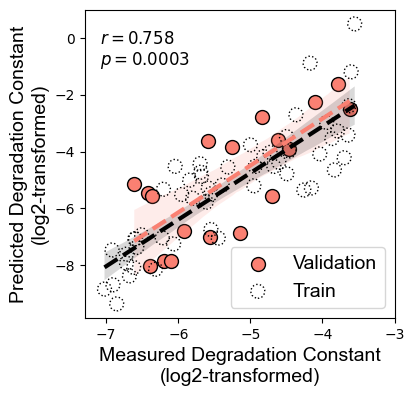

In [683]:
from scipy.stats import pearsonr
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot()
pred = best_models[np.argmin(pvals)].best_estimator_.predict(validation_df[non_zero_features].values)
val = validation_df['log2(Deg constant)']

pred_train = best_models[np.argmin(pvals)].best_estimator_.predict(train_df[non_zero_features].values)
t_train = train_df['log2(Deg constant)']


ax.scatter(pred,val,color='salmon',ec='black',s=100,label='Validation')
sns.regplot(x=pred,y=val,scatter=False,color='salmon',line_kws={'lw':3,'ls':'--'})

ax.scatter(pred_train,t_train,fc='None',ec='black',s=100,ls=':',label='Train')
sns.regplot(x=pred_train,y=t_train,scatter=False,color='black',line_kws={'lw':3,'ls':'--'})
ax.legend(loc=4,prop={'family':'Arial','size':14})

r,p = pearsonr(val,pred)
ax.text(0.05,0.82,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax.transAxes,fontsize=12,fontname='Arial',ha='left')
ax.set_xlim(-7.3,-3)
ax.set_xlabel('Measured Degradation Constant\n(log2-transformed)',fontsize=14,fontname='Arial')
ax.set_ylabel('Predicted Degradation Constant\n(log2-transformed)',fontsize=14,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_hyperparameter_finetuning_mini.svg',
            bbox_inches='tight')

In [684]:
import pickle as pk
pk.dump(best_models[np.argmin(pvals)].best_estimator_,
        open('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/202311_best_pred_model_minimum_feature.pk','wb'))

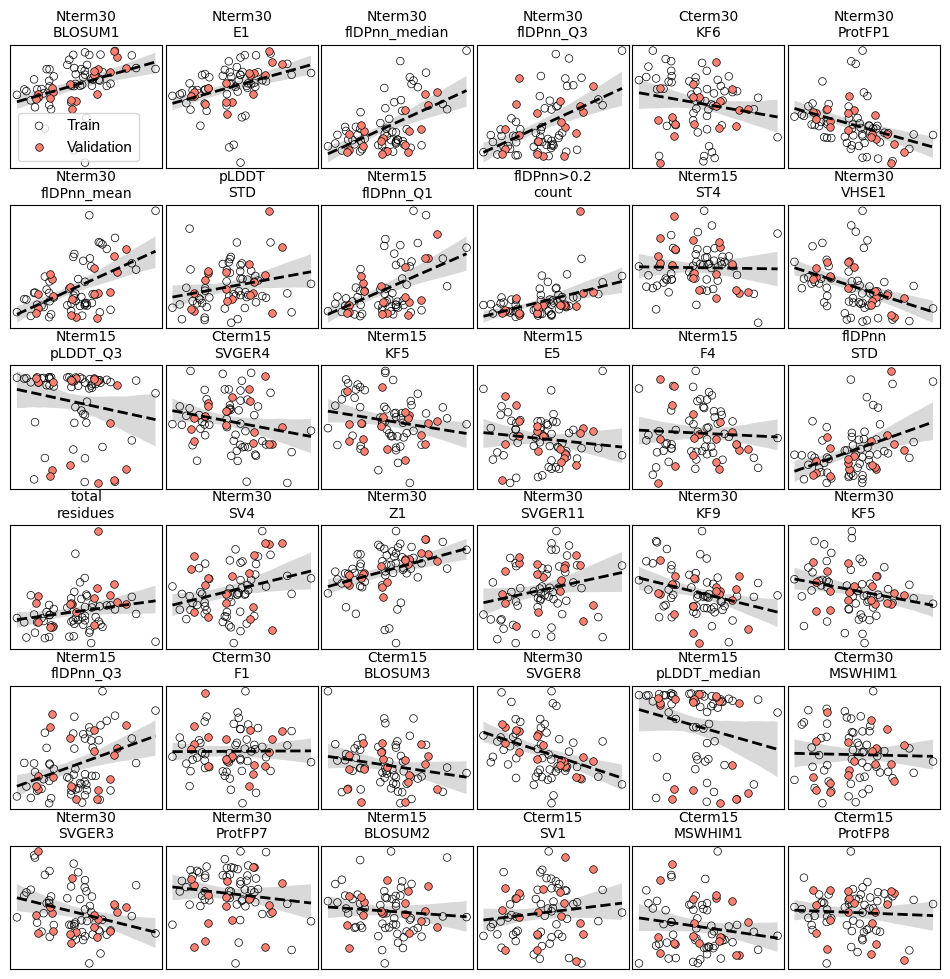

In [685]:
fig = plt.figure(figsize=(12,10))
grids=gs(8,5,hspace=0.3,wspace=0.02)

for i,f in enumerate(non_zero_features[np.flip(np.argsort(best_models[np.argmin(pvals)].best_estimator_.feature_importances_))]):
    if i<40:
        r=int(i/8)
        c=i%8
        ax=fig.add_subplot(grids[r,c])
        ax.set_xticks([])
        ax.set_yticks([])
        v = pooled_stats[f].values
        t = pooled_stats['log2(Deg constant)'].values
        sns.regplot(x=t,y=v,ax=ax,scatter=False,
                    line_kws={'color':'black','ls':'--','lw':2})
        v_train,t_train = train_df[[f,'log2(Deg constant)']].values.T
        v_val,t_val = validation_df[[f,'log2(Deg constant)']].values.T
        #ax.set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()*1.2)
        if i==0:
            ax.scatter(t_train,v_train,s=30,ec='black',fc='None',label='Train',lw=0.5)
            ax.scatter(t_val,v_val,s=30,ec='black',fc='salmon',label='Validation',lw=0.5)
            #ax.set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()*1.2)
            ax.legend(loc=0,prop={'family':'Arial','size':11})
        else:
            ax.scatter(t_train,v_train,s=30,ec='black',fc='None',lw=0.5)
            ax.scatter(t_val,v_val,s=30,ec='black',fc='salmon',lw=0.5)
        ax.set_title('{}\n{}'.format(f.split('_')[0],
                                     '_'.join(f.split('_')[1:])),fontsize=10)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_feature_landscape.svg',
            bbox_inches='tight')

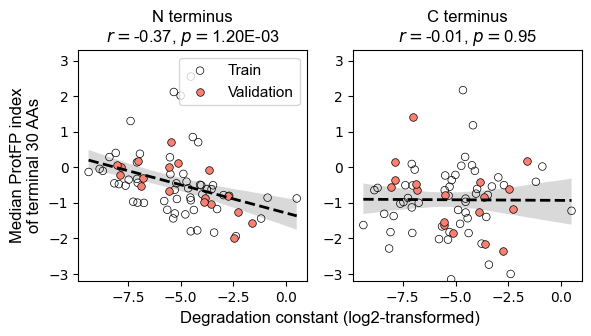

In [686]:
fig,axes=plt.subplots(figsize=(6.5,3),ncols=2)
for i,f in enumerate(['Nterm30_ProtFP1','Cterm30_ProtFP1']):
    v = pooled_stats[f].values
    t = pooled_stats['log2(Deg constant)'].values
    sns.regplot(x=t,y=v,scatter=False,
                line_kws={'color':'black','ls':'--','lw':2},ax=axes[i])
    v_train,t_train = train_df[[f,'log2(Deg constant)']].values.T
    v_val,t_val = validation_df[[f,'log2(Deg constant)']].values.T
    if i==0:
        axes[i].scatter(t_train,v_train,s=30,ec='black',fc='None',label='Train',lw=0.5)
        axes[i].scatter(t_val,v_val,s=30,ec='black',fc='salmon',label='Validation',lw=0.5)
        axes[i].set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()*1.2)
        axes[i].legend(loc=0,prop={'family':'Arial','size':11})
        axes[i].set_ylim(-3.2,3.3)
    else:
        axes[i].scatter(t_train,v_train,s=30,ec='black',fc='None',lw=0.5)
        axes[i].scatter(t_val,v_val,s=30,ec='black',fc='salmon',lw=0.5)
        axes[i].set_ylim(-3.2,3.3)
    r,p = pearsonr(v,t)
    if p<0.05:
        axes[i].set_title('N terminus\n$r=${}, $p=${:.2E}'.format(round(r,2),p),fontname='Arial',fontsize=12)
    else:
        axes[i].set_title('C terminus\n$r=${}, $p=${}'.format(round(r,2),round(p,2)),fontname='Arial',fontsize=12)
axes[0].set_ylabel('Median ProtFP index\nof terminal 30 AAs',fontname='Arial',fontsize=12)
axes[0].text(1.1,-0.13,'Degradation constant (log2-transformed)',fontname='Arial',fontsize=12,transform=axes[0].transAxes,ha='center',va='top')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_term_ProtFP_median.svg',
            bbox_inches='tight')

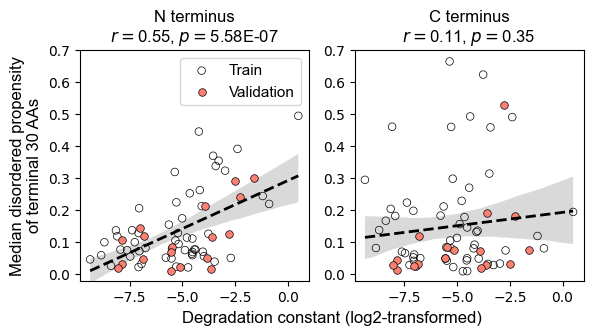

In [687]:
fig,axes=plt.subplots(figsize=(6.5,3),ncols=2)
for i,f in enumerate(['Nterm30_flDPnn_median','Cterm30_flDPnn_median']):
    v = pooled_stats[f].values
    t = pooled_stats['log2(Deg constant)'].values
    sns.regplot(x=t,y=v,scatter=False,
                line_kws={'color':'black','ls':'--','lw':2},ax=axes[i])
    v_train,t_train = train_df[[f,'log2(Deg constant)']].values.T
    v_val,t_val = validation_df[[f,'log2(Deg constant)']].values.T
    if i==0:
        axes[i].scatter(t_train,v_train,s=30,ec='black',fc='None',label='Train',lw=0.5)
        axes[i].scatter(t_val,v_val,s=30,ec='black',fc='salmon',label='Validation',lw=0.5)
        axes[i].set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()*1.2)
        axes[i].legend(loc=0,prop={'family':'Arial','size':11})
        axes[i].set_ylim(-0.02,0.7)
    else:
        axes[i].scatter(t_train,v_train,s=30,ec='black',fc='None',lw=0.5)
        axes[i].scatter(t_val,v_val,s=30,ec='black',fc='salmon',lw=0.5)
        axes[i].set_ylim(-0.02,0.7)
    r,p = pearsonr(v,t)
    if p<0.05:
        axes[i].set_title('N terminus\n$r=${}, $p=${:.2E}'.format(round(r,2),p),fontname='Arial',fontsize=12)
    else:
        axes[i].set_title('C terminus\n$r=${}, $p=${}'.format(round(r,2),round(p,2)),fontname='Arial',fontsize=12)
axes[0].set_ylabel('Median disordered propensity\nof terminal 30 AAs',fontname='Arial',fontsize=12)
axes[0].text(1.1,-0.13,'Degradation constant (log2-transformed)',fontname='Arial',fontsize=12,transform=axes[0].transAxes,ha='center',va='top')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_term_flDPnn_median.svg',
            bbox_inches='tight')

In [688]:
for f in non_zero_features:
    v = pooled_stats[f].values
    t = pooled_stats['log2(Deg constant)'].values
    if pearsonr(v,t)[1]<0.05:
        print(f)

flDPnn_STD
flDPnn>0.2_count
pLDDT_STD
Cterm15_KF6
Nterm15_flDPnn_Q1
Nterm15_flDPnn_Q3
Nterm30_BLOSUM1
Nterm30_BLOSUM4
Nterm30_KF5
Nterm30_KF9
Nterm30_E1
Nterm30_ProtFP1
Nterm30_SV4
Nterm30_SVGER3
Nterm30_SVGER8
Nterm30_SVGER11
Nterm30_VHSE1
Nterm30_Z1
Nterm30_flDPnn_mean
Nterm30_flDPnn_median
Nterm30_flDPnn_Q3


In [757]:
manuel_select_features = ['flDPnn_STD','flDPnn>0.2_count','Cterm15_flDPnn_mean',
                          'total_residues',
                          'pLDDT_STD','Cterm15_KF6','Nterm30_ProtFP1',
                          'Nterm15_flDPnn_mean','Nterm30_E1','Nterm30_flDPnn_mean']

In [758]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso

In [764]:
m=lr().fit(train_df[non_zero_features].values,
              train_df['log2(Deg constant)'].values)
pred = m.predict(validation_df[non_zero_features].values)

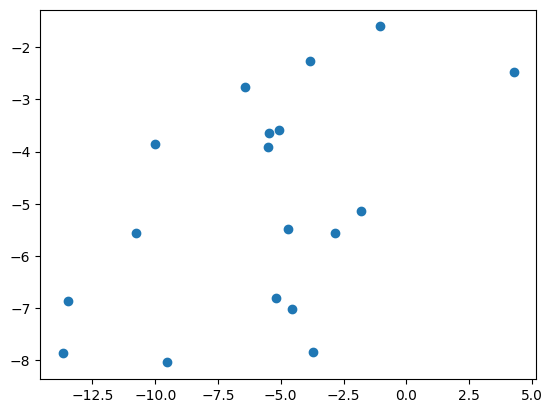

In [765]:
plt.scatter(pred,validation_df['log2(Deg constant)'])

In [761]:
ortho_table = pd.read_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/union_ortho_table_withFeatures.csv')

In [766]:
ortho_table['Pred'] = m.predict(ortho_table[non_zero_features].values)

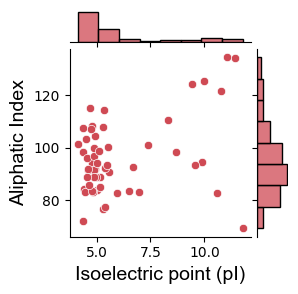

In [790]:
sns.set_palette(palette=[np.array([207,74,84])/255])
g=sns.jointplot(data=train_df,x='Msm_PI',y='Msm_Aliphatic_Index',height=3)
g.ax_joint.set_xlabel('Isoelectric point (pI)',fontname='Arial',fontsize=14)
g.ax_joint.set_ylabel('Aliphatic Index',fontname='Arial',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_training_features.svg',
            bbox_inches='tight')